In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore')
import pandas as pd
import platform
import matplotlib
import matplotlib.pyplot as plt
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    matplotlib.rc('font', family='AppleGothic')
else:
    matplotlib.rc('font', family='NanumGothic')
    
# tensorflow warning off
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)    

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras.models import Model

from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'

def mish(x):
    return x * K.tanh(K.softplus(x))

get_custom_objects().update({'mish': Mish(mish)})

# 묶어서

input_data_2.xlsx에서, 누적데이터의 의미가 사라지는 경기 한 두번만 한 데이터는 삭제하여 input_data_3.xlsx 생성함.

In [3]:
df_total = pd.read_excel('input_data_3.xlsx')

In [4]:
df_total.corr()['RUN']

year       -0.260338
경기수        -0.051461
누적경기수      -0.028567
피장타율        0.019916
방어율         0.041487
삼진/볼넷      -0.002584
피출루율        0.064685
피OPS        0.036986
9이닝당 삼진수   -0.041129
9이닝당 볼넷수    0.044398
잔루처리율      -0.047577
해당경기 실점     0.762928
cOBP        0.366851
cSLG        0.438801
cOPS        0.433589
cBABIP      0.273871
KK/BB      -0.147787
wOBA        0.436141
WLD         0.161506
PARK        0.111454
BPF         0.180707
PPF         0.151780
피장타율_       0.162948
방어율_        0.164221
삼진/볼넷_     -0.075382
피출루율_       0.094825
피OPS_       0.147830
9이닝당삼진수_    0.011909
9이닝당볼넷수_    0.066101
잔루처리율_     -0.051008
RUN         1.000000
Name: RUN, dtype: float64

In [5]:
del df_total['9이닝당 삼진수'];del df_total['9이닝당 볼넷수'];del df_total['9이닝당삼진수_'];del df_total['9이닝당볼넷수_']; #삭제 판단

In [6]:
df_total.dropna(inplace = True)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_set, test_set=train_test_split(df_total,test_size=0.2,random_state=666)

In [9]:
print(train_set.shape, test_set.shape)

(124, 29) (31, 29)


In [10]:
import numpy as np

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
input_a1 = train_set.iloc[:, 12:18] # 타자 데이터(train)

input_b1 = train_set.iloc[:,4:11] # 선발투수 데이터(train)
input_b2 = train_set.iloc[:, 22:28] # 중간계투 데이터(train)

input_c1 = train_set.iloc[:, 18:22] # 파크팩터(train)


tinput_a1 = test_set.iloc[:, 12:18]# 타자 데이터(train)

tinput_b1 = test_set.iloc[:, 4:11]# 선발투수 데이터(train)
tinput_b2 =test_set.iloc[:, 22:28]  # 중간계투 데이터(train)

tinput_c1 = test_set.iloc[:, 18:22] # 파크팩터(train)
input_c1

,WLD,PARK,BPF,PPF
94,0.400000,1002.500000,0.872587,0.878518
179,0.237500,1031.750000,0.871067,0.874504
0,0.566667,1000.000000,0.858404,0.879156
105,0.475000,1083.000000,0.883018,0.893453
87,0.666667,938.000000,0.831685,0.798610
...,...,...,...,...
73,0.350000,964.000000,0.871238,0.869567
131,0.380000,993.600000,0.873733,0.876009
100,0.520000,1007.800000,0.854462,0.856262
89,0.650000,1028.500000,0.892555,0.896712


In [13]:
input_a1 = scaler.fit_transform(input_a1)
input_b1 = scaler.fit_transform(input_b1)
input_b2 = scaler.fit_transform(input_b2)
input_c1 = scaler.fit_transform(input_c1)

tinput_a1 = scaler.fit_transform(tinput_a1)
tinput_b1 = scaler.fit_transform(tinput_b1)
tinput_b2 = scaler.fit_transform(tinput_b2)
tinput_c1 = scaler.fit_transform(tinput_c1)

In [14]:
Output = train_set.iloc[:, -1:]
y = test_set.iloc[:, -1:]

득점예측은 딥러닝으로 한다. activation은 relu랑 selu,mish 중 가장 높은 정확도를 가지는 것으로 결정

In [15]:
input_A1 = tf.keras.layers.Input(shape=[input_a1.shape[1]], name = "bat_input_1") # 타자
input_B1 = tf.keras.layers.Input(shape=[input_b1.shape[1]], name = "pit_input_1") # 선발투수
input_B2 = tf.keras.layers.Input(shape=[input_b2.shape[1]], name = "pit_input_2") # 중간계투
input_C1 = tf.keras.layers.Input(shape=[input_c1.shape[1]], name = "external_factor") # 외적 요인

##########################################################################

hidden_A00 = tf.keras.layers.Dense(256, activation = "mish")(input_A1)
# drop_A00 = tf.keras.layers.Dropout(0.5)(hidden_A00)

hidden_A01 = tf.keras.layers.Dense(64, activation = "mish")(hidden_A00)
# drop_A01 = tf.keras.layers.Dropout(0.5)(hidden_A01)

hidden_A02 = tf.keras.layers.Dense(32, activation = "mish")(hidden_A01)
drop_A02 = tf.keras.layers.Dropout(0.5)(hidden_A02)

hidden_A03 = tf.keras.layers.Dense(32, activation = "mish")(drop_A02)
# drop_A03 = tf.keras.layers.Dropout(0.5)(hidden_A03)

hidden_A04 = tf.keras.layers.Dense(32, activation = "mish")(hidden_A03)
drop_A04 = tf.keras.layers.Dropout(0.5)(hidden_A04)

hidden_A05 = tf.keras.layers.Dense(32, activation = "mish")(drop_A04)
# drop_A05 = tf.keras.layers.Dropout(0.5)(hidden_A05)

hidden_A06 = tf.keras.layers.Dense(16, activation = "mish")(hidden_A05)
drop_A06 = tf.keras.layers.Dropout(0.5)(hidden_A06)

hidden_A07 = tf.keras.layers.Dense(16, activation = "mish")(drop_A06)
# hidden_A08 = tf.keras.layers.Dense(30, activation = "mish")(hidden_A07)
# drop_A08 = tf.keras.layers.Dropout(0.5)(hidden_A08)

# hidden_A09 = tf.keras.layers.Dense(30, activation = "mish")(drop_A08)
# hidden_A10 = tf.keras.layers.Dense(30, activation = "mish")(hidden_A09)
# hidden_A11 = tf.keras.layers.Dense(30, activation = "mish")(hidden_A10)
# hidden_A12 = tf.keras.layers.Dense(30, activation = "mish")(hidden_A11)

##########################################################################

hidden_B00 = tf.keras.layers.Dense(256, activation = "mish")(input_B1)
# drop_B00 = tf.keras.layers.Dropout(0.5)(hidden_B00)

hidden_B01 = tf.keras.layers.Dense(64, activation = "mish")(hidden_B00)
# drop_B01 = tf.keras.layers.Dropout(0.5)(hidden_B01)

hidden_B02 = tf.keras.layers.Dense(32, activation = "mish")(hidden_B01)
drop_B02 = tf.keras.layers.Dropout(0.5)(hidden_B02)

hidden_B03 = tf.keras.layers.Dense(32, activation = "mish")(drop_B02)
# drop_B03 = tf.keras.layers.Dropout(0.5)(hidden_B03)

hidden_B04 = tf.keras.layers.Dense(32, activation = "mish")(hidden_B03)
drop_B04 = tf.keras.layers.Dropout(0.5)(hidden_B04)

hidden_B05 = tf.keras.layers.Dense(32, activation = "mish")(drop_B04)
# drop_B05 = tf.keras.layers.Dropout(0.5)(hidden_B05)

hidden_B06 = tf.keras.layers.Dense(16, activation = "mish")(hidden_B05)
drop_B06 = tf.keras.layers.Dropout(0.5)(hidden_B06)

hidden_B07 = tf.keras.layers.Dense(16, activation = "mish")(drop_B06)
# hidden_B08 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B07)
# drop_B08 = tf.keras.layers.Dropout(0.5)(hidden_B08)

# hidden_B09 = tf.keras.layers.Dense(30, activation = "mish")(drop_B08)
# hidden_B10 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B09)
# hidden_B11 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B10)
# hidden_B12 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B11)

##########################################################################

hidden_B20 = tf.keras.layers.Dense(256, activation = "mish")(input_B2)
# drop_B20 = tf.keras.layers.Dropout(0.5)(hidden_B20)

hidden_B21 = tf.keras.layers.Dense(64, activation = "mish")(hidden_B20)
# drop_B21 = tf.keras.layers.Dropout(0.5)(hidden_B21)

hidden_B22 = tf.keras.layers.Dense(32, activation = "mish")(hidden_B21)
drop_B22 = tf.keras.layers.Dropout(0.5)(hidden_B22)

hidden_B23 = tf.keras.layers.Dense(32, activation = "mish")(drop_B22)
# drop_B23 = tf.keras.layers.Dropout(0.5)(hidden_B23)

hidden_B24 = tf.keras.layers.Dense(32, activation = "mish")(hidden_B23)
drop_B24 = tf.keras.layers.Dropout(0.5)(hidden_B24)

hidden_B25 = tf.keras.layers.Dense(32, activation = "mish")(drop_B24)
# drop_B25 = tf.keras.layers.Dropout(0.5)(hidden_B25)

hidden_B26 = tf.keras.layers.Dense(16, activation = "mish")(hidden_B25)
drop_B26 = tf.keras.layers.Dropout(0.5)(hidden_B26)

hidden_B27 = tf.keras.layers.Dense(16, activation = "mish")(drop_B26)
# hidden_B28 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B27)
# drop_B28 = tf.keras.layers.Dropout(0.5)(hidden_B28)

# hidden_B29 = tf.keras.layers.Dense(30, activation = "mish")(drop_B28)
# hidden_B30 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B29)
# hidden_B31 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B30)
# hidden_B32 = tf.keras.layers.Dense(30, activation = "mish")(hidden_B31)

##########################################################################

hidden_C00 = tf.keras.layers.Dense(256, activation = "mish")(input_C1)
# drop_C00 = tf.keras.layers.Dropout(0.5)(hidden_C00)

hidden_C01 = tf.keras.layers.Dense(64, activation = "mish")(hidden_C00)
# drop_C01 = tf.keras.layers.Dropout(0.5)(hidden_C01)

hidden_C02 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C01)
drop_C02 = tf.keras.layers.Dropout(0.5)(hidden_C02)

hidden_C03 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C02)
# drop_C03 = tf.keras.layers.Dropout(0.5)(hidden_C03)

hidden_C04 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C03)
drop_C04 = tf.keras.layers.Dropout(0.5)(hidden_C04)

hidden_C05 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C04)
# drop_C05 = tf.keras.layers.Dropout(0.5)(hidden_C05)

hidden_C06 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C05)
# drop_C06 = tf.keras.layers.Dropout(0.5)(hidden_C06)

hidden_C07 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C06)
# drop_C07 = tf.keras.layers.Dropout(0.5)(hidden_C07)
hidden_C08 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C07)
# drop_C08 = tf.keras.layers.Dropout(0.5)(hidden_C08)

# hidden_C09 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C08)
# hidden_C10 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C09)
# hidden_C11 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C10)
# hidden_C12 = tf.keras.layers.Dense(32, activation = "mish")(hidden_C11)

concat = tf.keras.layers.concatenate([hidden_A07, hidden_B07, hidden_B27, hidden_C08])
output = tf.keras.layers.Dense(1, name = "output")(concat)
model = tf.keras.Model(inputs = [input_A1, input_B1, input_B2, input_C1], outputs = [output])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bat_input_1 (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
pit_input_1 (InputLayer)        [(None, 7)]          0                                            
__________________________________________________________________________________________________
pit_input_2 (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1792        bat_input_1[0][0]                
______________________________________________________________________________________________

In [17]:
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae'])

In [18]:
history = model.fit([input_a1, input_b1, input_b2, input_c1], [Output], epochs = 50)

Train on 124 samples
Epoch 1/50
124/124 [==============================] - 6s 49ms/sample - loss: 5.0417 - mae: 5.0417
Epoch 2/50
124/124 [==============================] - 0s 547us/sample - loss: 4.8775 - mae: 4.8775
Epoch 3/50
124/124 [==============================] - 0s 555us/sample - loss: 4.5463 - mae: 4.5463
Epoch 4/50
124/124 [==============================] - 0s 521us/sample - loss: 3.9284 - mae: 3.9284
Epoch 5/50
124/124 [==============================] - 0s 603us/sample - loss: 2.6747 - mae: 2.6747
Epoch 6/50
124/124 [==============================] - 0s 539us/sample - loss: 1.8959 - mae: 1.8959
Epoch 7/50
124/124 [==============================] - 0s 527us/sample - loss: 2.2253 - mae: 2.2253
Epoch 8/50
124/124 [==============================] - 0s 547us/sample - loss: 1.7581 - mae: 1.7581
Epoch 9/50
124/124 [==============================] - 0s 555us/sample - loss: 1.8011 - mae: 1.8011
Epoch 10/50
124/124 [==============================] - 0s 519us/sample - loss: 1.7527 - m

In [19]:
pred = model.predict((tinput_a1, tinput_b1, tinput_b2, tinput_c1))

In [20]:
test = model.evaluate((input_a1, input_b1, input_b2, input_c1), (Output))

124/124 [==============================] - 1s 5ms/sample - loss: 1.4693 - mae: 1.4693


In [21]:
test = model.evaluate((tinput_a1, tinput_b1, tinput_b2, tinput_c1), (y))

31/31 [==============================] - 0s 322us/sample - loss: 1.6142 - mae: 1.6142


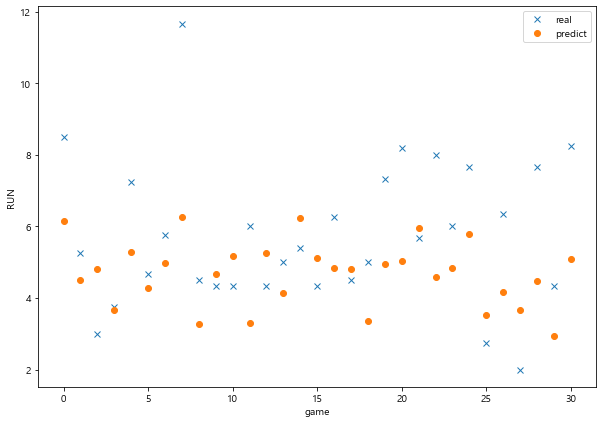

In [22]:
x = range(len(y))
y = y
y2 = pred
plt.figure(figsize = (10, 7))
plt.plot(x, y,'x', label = 'real')
plt.plot(x, y2, 'o', label = 'predict')
plt.xlabel('game')
plt.ylabel('RUN')
plt.legend(loc = 'upper right')
plt.show()